In [1]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [34]:
import numpy as np
import pandas as pd

In [59]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[0:10000], data[10000:14980]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/10))
	test = array(split(test, len(test)/10))
	train = train.reshape(train.shape[0], train.shape[1], 1) # 1 being the number of features [samples,timesteps, features]
	test = test.reshape(test.shape[0],test.shape[1], 1) # 1 being the number of features [samples,timesteps, features]    
	return train, test

In [70]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [74]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	max_steps = int(len(data)/20)    
	train, test = data[0:5000], data[5000:14980]
	# restructure into windows of 20-step data
	train = rolling_window(train, 10)
	test = rolling_window(test, 10)
	# place it in a dataframe
	trainDF = pd.DataFrame(data=train)
	testDF = pd.DataFrame(data=test)
	# name columns  
	cols_train = trainDF.columns.tolist()
	cols_test = testDF.columns.tolist()
	# rearrange columns      
	cols_train = cols_train[::-1]
	cols_test = cols_test[::-1]
	# rearrange dataframe   
	trainDF = trainDF[cols_train] 
	testDF = testDF[cols_test]
	# extract values
	train =trainDF.values
	test = testDF.values
	# reshape values    
	train = train.reshape(train.shape[0], train.shape[1], 1) # 1 being the number of features [samples,timesteps, features]
	test = test.reshape(test.shape[0],test.shape[1], 1) # 1 being the number of features [samples,timesteps, features]    
	return train, test

In [4]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [5]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	print(actual.shape)
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [6]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [22]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=10):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [60]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 3, 32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# define checkpoint
	checkpointer = ModelCheckpoint(filepath="lstm3_10steps.hdf5", verbose=1, save_best_only=False)
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[checkpointer])
	return model

In [50]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 3, 128
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# define checkpoint
	checkpointer = ModelCheckpoint(filepath="ed_lstm_10steps.hdf5", verbose=1, save_best_only=False)
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[checkpointer])
	return model

In [47]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 3, 128
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# define checkpoint
	checkpointer = ModelCheckpoint(filepath="cnn_lstm_10steps.hdf5", verbose=1, save_best_only=False)
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[checkpointer])
	return model

In [11]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [12]:
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :], predictions)
#	score, scores = 0, 0
	return score, scores, predictions

In [13]:
# load the new data file
dataset = read_csv('batch2.csv')

In [14]:
# extracting a single feature
X0 = dataset.c

In [76]:
# split into train and test
train, test = split_dataset(X0.values)

In [77]:
test.shape

(9971, 10, 1)

In [78]:
# evaluate model and get scores
n_input = 10
score_lstm, scores_LSTM, predictions_LSTM = evaluate_model(train, test, n_input)


Epoch 00001: saving model to lstm3_10steps.hdf5

Epoch 00002: saving model to lstm3_10steps.hdf5

Epoch 00003: saving model to lstm3_10steps.hdf5
(9971, 10, 1)


In [51]:
# evaluate model and get scores
n_input = 10
score_ED_LSTM, scores_ED_LSTM, predictions_ED = evaluate_model(train, test, n_input)


Epoch 00001: saving model to ed_lstm_10steps.hdf5

Epoch 00002: saving model to ed_lstm_10steps.hdf5

Epoch 00003: saving model to ed_lstm_10steps.hdf5
(13971, 10, 1)


In [48]:
# evaluate model and get scores
n_input = 10
score_CNN_LSTM, scores_CNN_LSTM, predictions_CNN = evaluate_model(train, test, n_input)


Epoch 00001: saving model to cnn_lstm_10steps.hdf5

Epoch 00002: saving model to cnn_lstm_10steps.hdf5

Epoch 00003: saving model to cnn_lstm_10steps.hdf5
(13971, 10, 1)


LSTM: [0.117] 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1
ED_LSTM: [0.162] 0.2, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2
CNN_LSTM: [0.144] 0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1


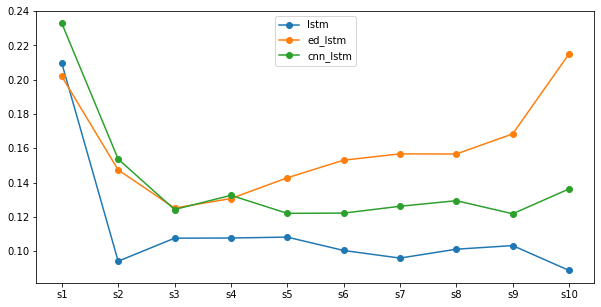

In [79]:
# summarize scores
summarize_scores('LSTM', score_lstm, scores_LSTM)
summarize_scores('ED_LSTM', score_ED_LSTM, scores_ED_LSTM)
summarize_scores('CNN_LSTM', score_CNN_LSTM, scores_CNN_LSTM)
# plot scores
days = ['s1', 's2', 's3', 's4', 's5', 's6', 's7','s8','s9','s10']
pyplot.figure(figsize=(10,5))
pyplot.plot(days, scores_LSTM, marker='o', label='lstm')
pyplot.plot(days, scores_ED_LSTM, marker='o', label='ed_lstm')
pyplot.plot(days, scores_CNN_LSTM, marker='o', label='cnn_lstm')
pyplot.legend()
pyplot.show()

In [134]:
len(X0[8:88])

80

In [135]:
test[:,1]

array([[-0.15363863],
       [ 0.0182711 ],
       [ 0.0170123 ],
       [-0.07504181],
       [-0.07440199],
       [-0.05295769],
       [-0.00076539],
       [-0.05956928],
       [-0.05336693]])

In [65]:
predictions_LSTM.shape

(498, 10)

In [177]:
predictions[0]

array([[0.1624855 ],
       [0.18480021],
       [0.19619197],
       [0.20233728],
       [0.20655884],
       [0.20893405],
       [0.21012604],
       [0.21064974],
       [0.2108132 ],
       [0.21079983],
       [0.21070789],
       [0.21059039],
       [0.21047135],
       [0.21036687],
       [0.21028064],
       [0.2102123 ],
       [0.21015967],
       [0.21012002],
       [0.21009064],
       [0.2100692 ]], dtype=float32)

In [179]:
import pandas as pd

In [210]:
predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])

In [80]:
predictionDF = pd.DataFrame(data=predictions_LSTM, columns=['s1', 's2', 's3', 's4', 's5', 's6', 's7',
                                                       's8','s9','s10'])

In [81]:
predictionDF.describe()

s1           s2           s3           s4           s5  \
count  9971.000000  9971.000000  9971.000000  9971.000000  9971.000000   
mean      0.050252     0.042930     0.039779     0.053910     0.045179   
std       0.499102     0.524172     0.505352     0.492591     0.498736   
min      -1.414772    -1.231173    -1.178534    -1.355998    -1.279180   
25%      -0.257335    -0.270766    -0.271215    -0.254825    -0.255496   
50%       0.159930     0.152904     0.140058     0.150347     0.146212   
75%       0.391274     0.428385     0.410105     0.418459     0.410696   
max       0.988184     1.108752     1.157204     1.183195     1.087871   

                s6           s7           s8           s9          s10  
count  9971.000000  9971.000000  9971.000000  9971.000000  9971.000000  
mean      0.034355     0.053983     0.030926     0.047959     0.057517  
std       0.515556     0.506343     0.521033     0.528220     0.514845  
min      -1.226150    -1.243034    -1.260708    -1.264158    -1.191966  
25%      -0.269516    -0.259639    -0.284799    -0.262915    -0.250954  
50%       0.139354     0.155807     0.150939     0.163046     0.169477  
75%       0.407808     0.419796     0.409933     0.430681     0.427903  
max       1.214192     1.245458     0.964580     1.059895     1.125240

In [86]:
predictionDF1 = pd.DataFrame(np.where(predictionDF > 1, 1, predictionDF))

In [87]:
predictionDF1.describe()

0            1            2            3            4  \
count  9971.000000  9971.000000  9971.000000  9971.000000  9971.000000   
mean      0.050252     0.042813     0.039600     0.053882     0.045159   
std       0.499102     0.523952     0.504996     0.492532     0.498696   
min      -1.414772    -1.231173    -1.178534    -1.355998    -1.279180   
25%      -0.257335    -0.270766    -0.271215    -0.254825    -0.255496   
50%       0.159930     0.152904     0.140058     0.150347     0.146212   
75%       0.391274     0.428385     0.410105     0.418459     0.410696   
max       0.988184     1.000000     1.000000     1.000000     1.000000   

                 5            6            7            8            9  
count  9971.000000  9971.000000  9971.000000  9971.000000  9971.000000  
mean      0.033937     0.053691     0.030926     0.047895     0.057340  
std       0.514719     0.505761     0.521033     0.528101     0.514506  
min      -1.226150    -1.243034    -1.260708    -1.264158    -1.191966  
25%      -0.269516    -0.259639    -0.284799    -0.262915    -0.250954  
50%       0.139354     0.155807     0.150939     0.163046     0.169477  
75%       0.407808     0.419796     0.409933     0.430681     0.427903  
max       1.000000     1.000000     0.964580     1.000000     1.000000

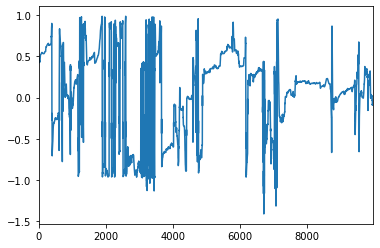

In [82]:
predictionDF['s1'].plot();

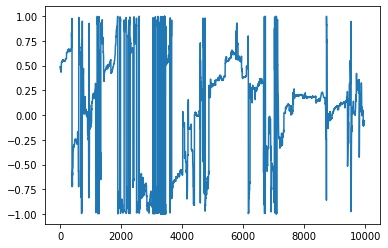

In [83]:
pyplot.plot(test[:, 0]);

In [216]:
t1 = dataset.TIME

In [217]:
t1[0]

'10:59:32.944'

In [218]:
t2 = dataset.TIME.shift(20)

In [220]:
from datetime import timedelta

In [222]:
t1_delta = timedelta(t1)

TypeError: unsupported type for timedelta days component: Series

In [223]:
t3 = pd.to_datetime(t1)

In [225]:
t4 = pd.to_datetime(t2)

In [226]:
t4[0] - t3[0]

NaT

In [234]:
t4[20].microsecond - t3[20].microsecond

719000